# Model
Use the following:
1. FeatureTransformer - Z-transform, then 4 RBFSamplers, which are initialized by picking 500 examplars from 10k samples from environment
2. 4 SGDRegressors - 1 for each action

# Environment
https://gymnasium.farama.org/environments/classic_control/mountain_car/
1. Action Space - 3 actions (accelerate left, stay, accelerate right)
2. Observation space - x-axis position, speed/velocity

In [1]:
import gymnasium as gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [2]:
env = gym.make('MountainCar-v0')
env.observation_space.sample()

array([0.38000324, 0.019758  ], dtype=float32)

In [3]:
env.action_space, env.action_space.sample()

(Discrete(3), 1)

In [4]:
# SGDRegressor defaults:
# loss='squared_loss', penalty='l2', alpha=0.0001,
# l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True,
# verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling',
# eta0=0.01, power_t=0.25, warm_start=False, average=False

# Inspired by https://github.com/dennybritz/reinforcement-learning
class FeatureTransformer:
  def __init__(self, env, n_components=500):
    observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # z-transform
    scaler = StandardScaler()
    scaler.fit(observation_examples)

    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    example_features = featurizer.fit_transform(scaler.transform(observation_examples))

    self.dimensions = example_features.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer

  def transform(self, observations):
    # print "observations:", observations
    scaled = self.scaler.transform(observations)
    # assert(len(scaled.shape) == 2)
    return self.featurizer.transform(scaled)

In [5]:
# Holds one SGDRegressor for each action
class Model:
  def __init__(self, env, feature_transformer, learning_rate):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer
    for i in range(env.action_space.n):
      model = SGDRegressor(learning_rate=learning_rate)
      obs = env.reset()[0]
      # optimistic initial values (see notes)
      model.partial_fit(feature_transformer.transform( [obs] ), [0])
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform([s])
    result = np.stack([m.predict(X) for m in self.models]).T
    assert(len(result.shape) == 2)
    return result

  def update(self, s, a, G):
    X = self.feature_transformer.transform([s])
    assert(len(X.shape) == 2)
    self.models[a].partial_fit(X, [G])

  def sample_action(self, s, eps):
    # eps = 0
    # Technically, we don't need to do epsilon-greedy
    # because SGDRegressor predicts 0 for all states
    # until they are updated. This works as the
    # "Optimistic Initial Values" method, since all
    # the rewards for Mountain Car are -1.
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))

In [6]:
# returns a list of states_and_rewards, and the total reward
def play_one(model, env, eps, gamma):
  observation = env.reset()[0]
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 10000:
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, trunc, info = env.step(action)

    # update the model
    next = model.predict(observation)
    # assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next[0])
    model.update(prev_observation, action, G)

    totalreward += reward
    iters += 1

  return totalreward

In [7]:
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  # both X and Y will be of shape (num_tiles, num_tiles)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))
  # Z will also be of shape (num_tiles, num_tiles)

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()

In [8]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

In [9]:
env = gym.make('MountainCar-v0')
ft = FeatureTransformer(env)
model = Model(env, ft, "constant")
gamma = 0.99

In [10]:
N = 150
totalrewards = np.empty(N)
for n in range(N):
    # eps = 1.0/(0.1*n+1)
    
    eps = 0.1*(0.97**n)
    if n == 199:
        print("eps:", eps)
        # eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(model, env, eps, gamma)
    totalrewards[n] = totalreward
    if (n + 1) % 100 == 0:
        print("episode:", n, "total reward:", totalreward)
print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
print("total steps:", -totalrewards.sum())


episode: 99 total reward: -161.0
avg reward for last 100 episodes: -134.09
total steps: 29719.0


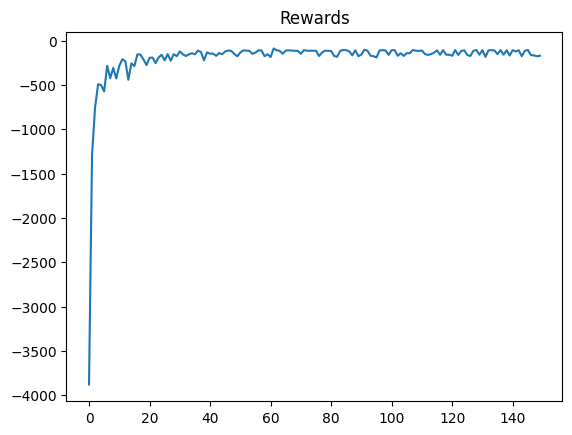

In [11]:
plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

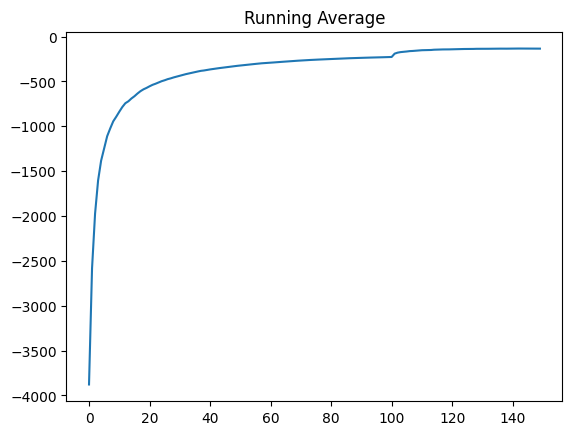

In [12]:
plot_running_avg(totalrewards)

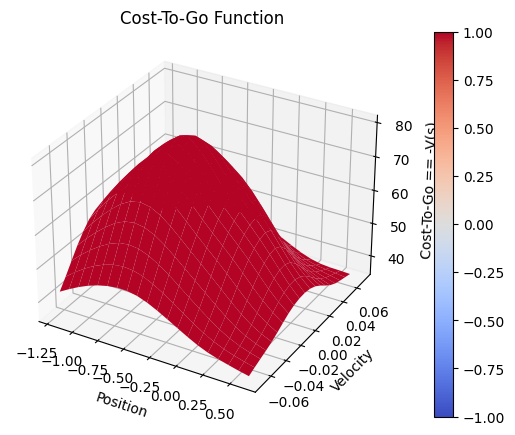

In [13]:
plot_cost_to_go(env, model)